In [0]:
data_test="/content/drive/My Drive/UCR_TS_Archive_2015/ECG5000/ECG5000_TEST"
data_train="/content/drive/My Drive/UCR_TS_Archive_2015/ECG5000/ECG5000_TRAIN"

In [0]:
import matplotlib.pyplot as plt
# import tensorflow
import numpy as np
import pandas as pd
from tensorflow.python import keras
#from tensorflow import keras
import os
import operator
import functools

In [0]:
def read_dataset(func):
  @functools.wraps(func)
  def dataset(params1, params2):
    data_train = np.loadtxt(params1, delimiter=',')
    data_test = np.loadtxt(params2, delimiter=',')
    train_Y = data_train[:, 0]
    train_X = data_train[:, 1:]
    test_Y = data_test[:, 0]
    test_X = data_test[:, 1:]
    return train_X, train_Y, test_X, test_Y
  return dataset

In [0]:
@read_dataset
def readucr(train_data, test_data):
    return train_X, train_Y, test_X, test_Y

In [0]:
x_train, y_train, x_test, y_test= readucr(data_train, data_test)

In [85]:
X = x_test
Y = y_test
import seaborn as sns
sns.set()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


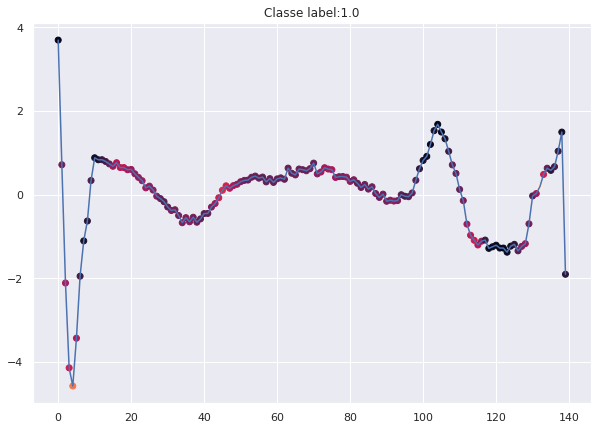

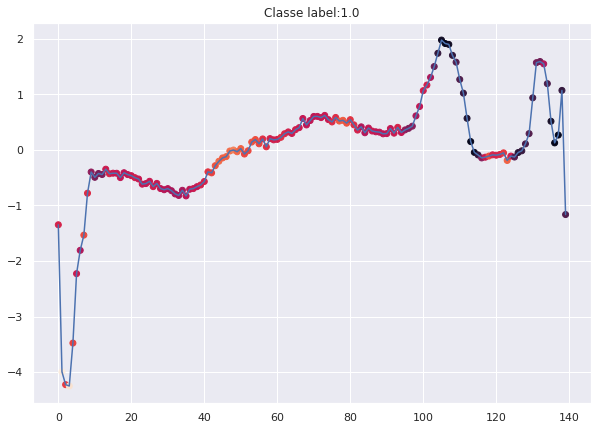

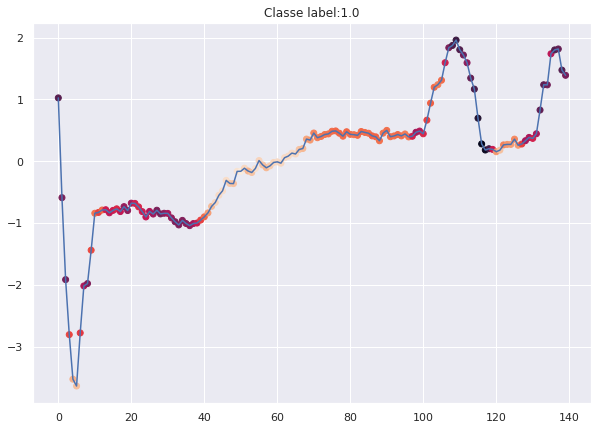

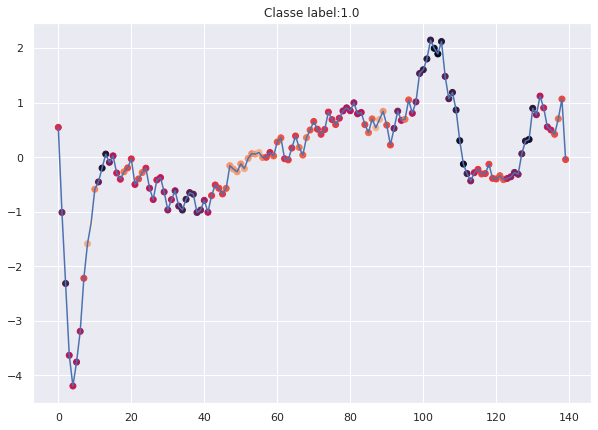

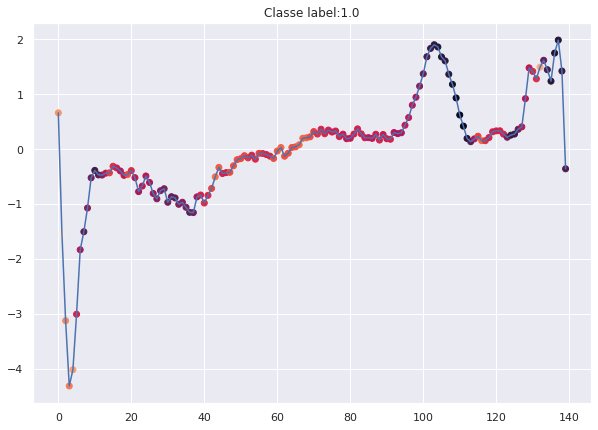

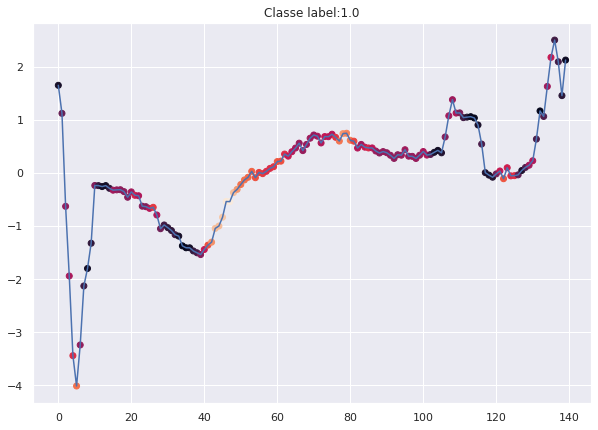

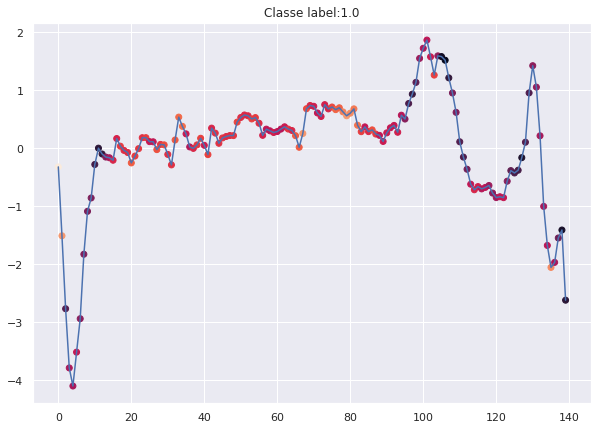

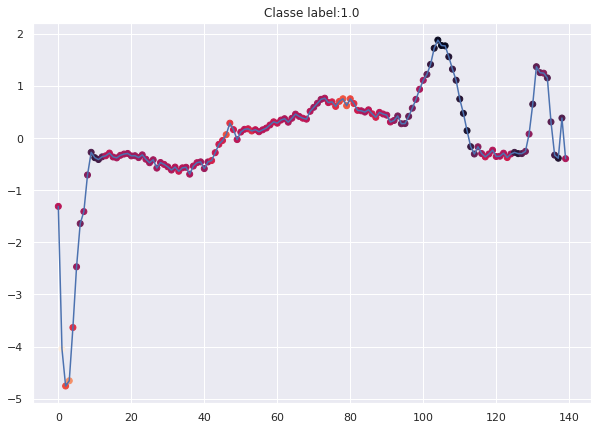

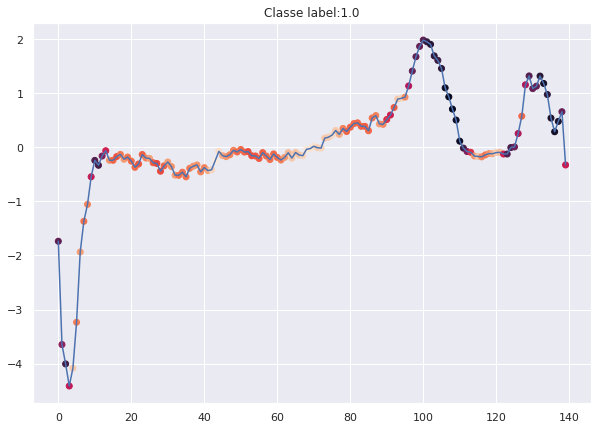

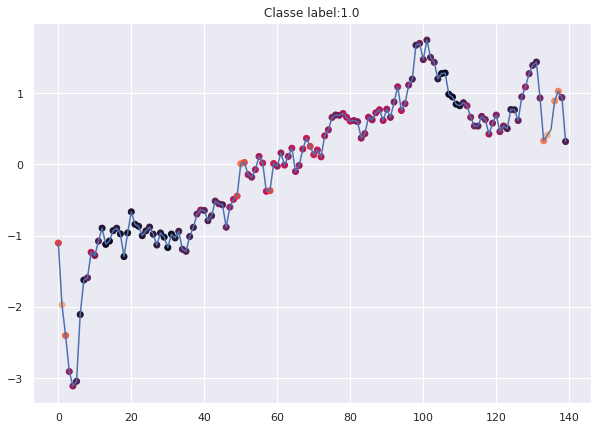

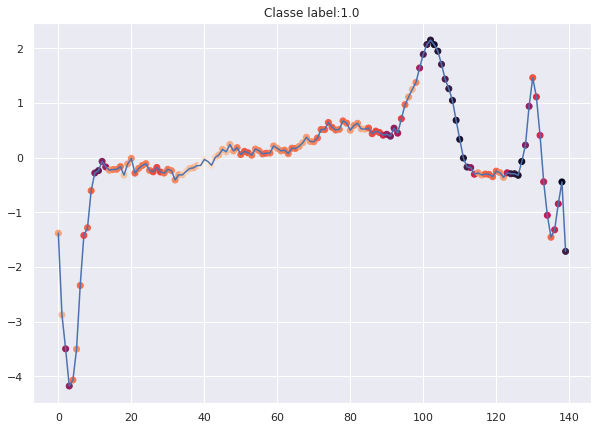

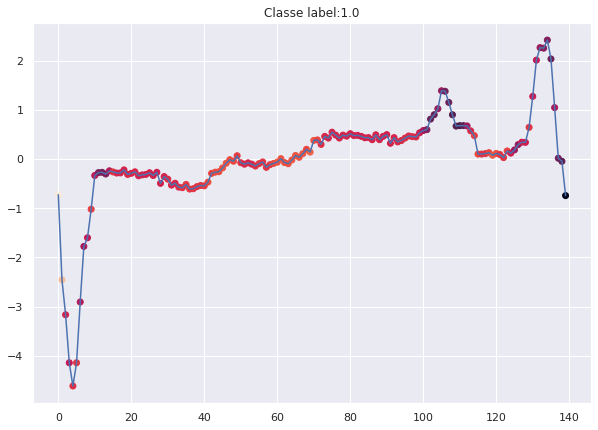

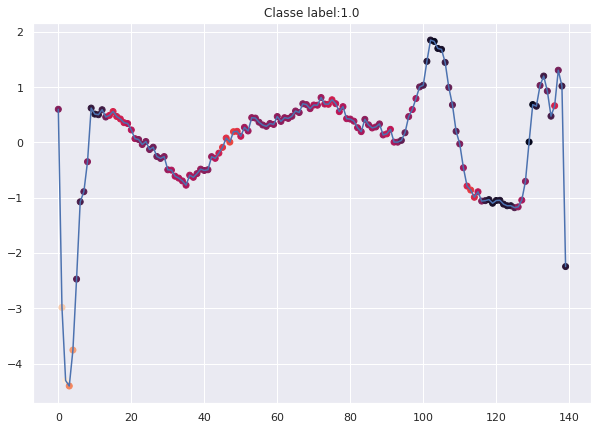

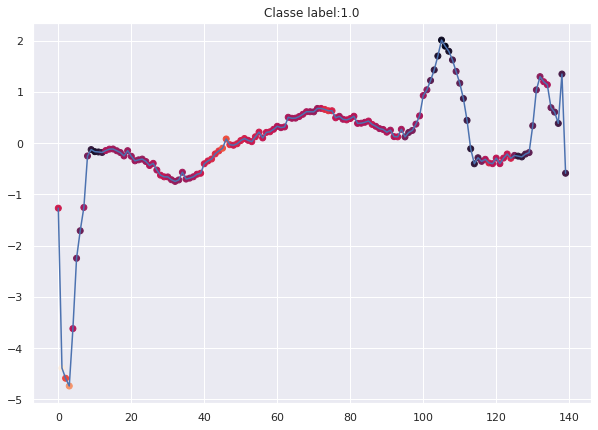

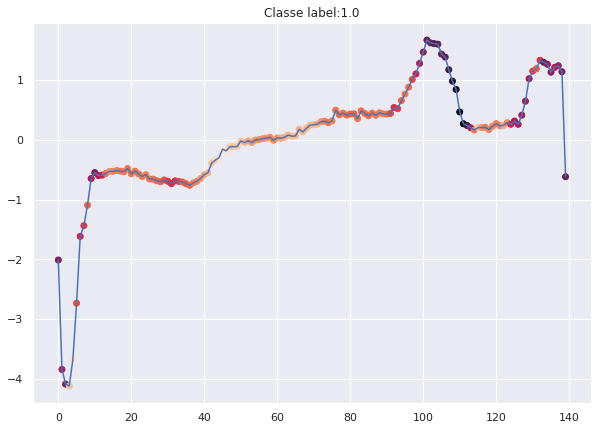

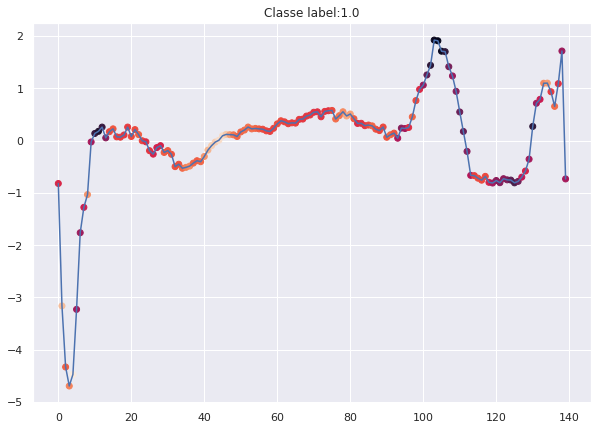

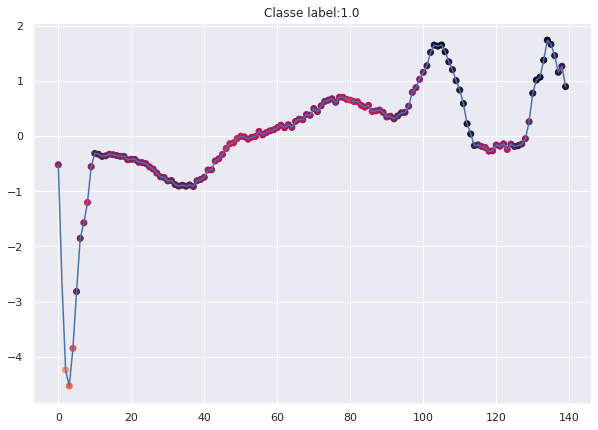

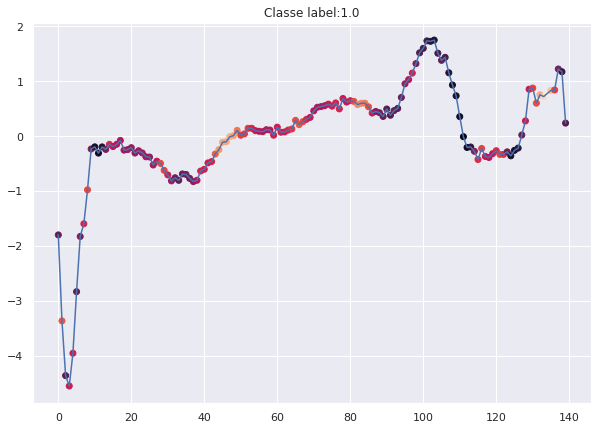

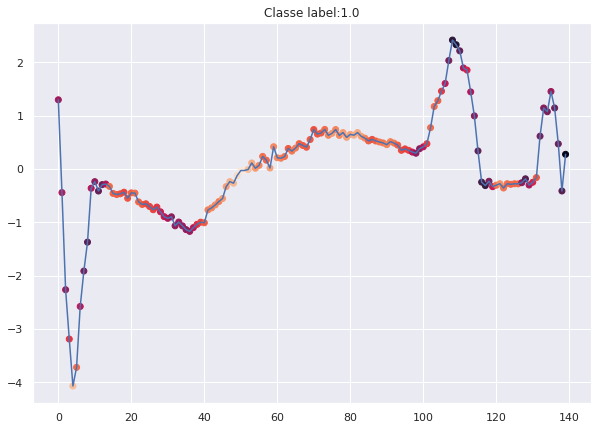

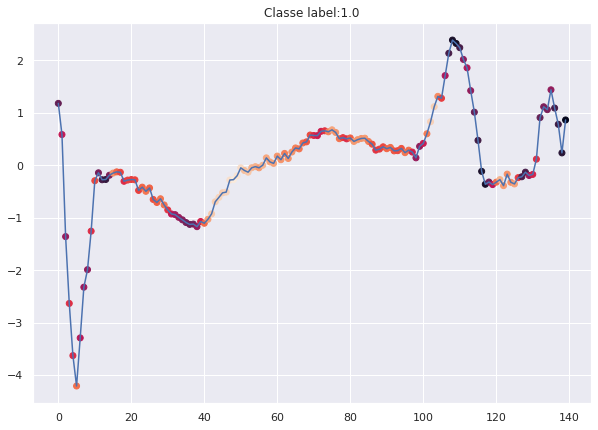

In [90]:
for k in range(20):
   plt.figure(figsize=(10, 7));
   plt.plot(X[k].squeeze());
   plt.scatter(np.arange(len(X[k])), X[k].squeeze(), c=c[k, :, :, int(Y[k])].squeeze());
   plt.title(
        'Classe label:' + str(Y[k]))
   plt.show()

In [0]:
print(len(x_train))

500


In [0]:
nb_classes =len(set(y_train))
batch_size = min(x_train.shape[0]/10, 16)
nb_classes, batch_size

(5, 16)

In [0]:
y_train = (y_train - y_train.min())/(y_train.max()-y_train.min())*(nb_classes-1)
y_test = (y_test - y_test.min())/(y_test.max()-y_test.min())*(nb_classes-1)

In [0]:
from keras.utils.np_utils import to_categorical
Y_train =to_categorical(y_train, nb_classes)
Y_test = to_categorical(y_test, nb_classes)

Using TensorFlow backend.


In [0]:
Y_train

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]], dtype=float32)

# z-normalisation des donnees d'apprentissage

In [0]:
x_train_mean = x_train.mean()
x_train_std = x_train.std()
x_train = (x_train - x_train_mean)/(x_train_std)

x_test_mean = x_test.mean()
x_test_std = x_test.std()    
x_test = (x_test - x_test_mean)/(x_test_std)

In [0]:
x_test.shape

(4500, 140)

In [0]:
x_train = x_train.reshape(x_train.shape + (1,1,))
x_test = x_test.reshape(x_test.shape + (1,1,))

In [0]:
x_test.shape

(4500, 140, 1, 1)

In [0]:
import tensorflow as tf

tf.compat.v1.disable_eager_execution()
def build_resnet(input_shape, n_feature_maps, nb_classes):
    print ('build conv_x')
    x = keras.layers.Input(shape=(input_shape))
    conv_x = keras.layers.BatchNormalization()(x)
    conv_x = keras.layers.Conv2D(n_feature_maps, 8, 1, padding='same')(conv_x)
    conv_x = keras.layers.BatchNormalization()(conv_x)
    conv_x = keras.layers.Activation('relu')(conv_x)
     
    print ('build conv_y')
    conv_y = keras.layers.Conv2D(n_feature_maps, 5, 1, padding='same')(conv_x)
    conv_y = keras.layers.BatchNormalization()(conv_y)
    conv_y = keras.layers.Activation('relu')(conv_y)
     
    print ('build conv_z')
    conv_z = keras.layers.Conv2D(n_feature_maps, 3, 1, padding='same')(conv_y)
    conv_z = keras.layers.BatchNormalization()(conv_z)
     
    is_expand_channels = not (input_shape[-1] == n_feature_maps)
    if is_expand_channels:
        shortcut_y = keras.layers.Conv2D(n_feature_maps, 1, 1,padding='same')(x)
        shortcut_y = keras.layers.BatchNormalization()(shortcut_y)
    else:
        shortcut_y = keras.layers.BatchNormalization()(x)
    print ('Merging skip connection')
    y = keras.layers.Add()([shortcut_y, conv_z])
    y = keras.layers.Activation('relu')(y)
     
    print ('build conv_x')
    x1 = y
    conv_x = keras.layers.Conv2D(n_feature_maps*2, 8, 1, padding='same')(x1)
    conv_x = keras.layers.BatchNormalization()(conv_x)
    conv_x = keras.layers.Activation('relu')(conv_x)
     
    print ('build conv_y')
    conv_y = keras.layers.Conv2D(n_feature_maps*2, 5, 1, padding='same')(conv_x)
    conv_y = keras.layers.BatchNormalization()(conv_y)
    conv_y = keras.layers.Activation('relu')(conv_y)
     
    print ('build conv_z')
    conv_z = keras.layers.Conv2D(n_feature_maps*2, 3, 1, padding='same')(conv_y)
    conv_z = keras.layers.BatchNormalization()(conv_z)
     
    is_expand_channels = not (input_shape[-1] == n_feature_maps*2)
    if is_expand_channels:
        shortcut_y = keras.layers.Conv2D(n_feature_maps*2, 1, 1,padding='same')(x1)
        shortcut_y = keras.layers.BatchNormalization()(shortcut_y)
    else:
        shortcut_y = keras.layers.BatchNormalization()(x1)
    print ('Merging skip connection')
    y = keras.layers.Add()([shortcut_y, conv_z])
    y = keras.layers.Activation('relu')(y)
     
    print ('build conv_x')
    x1 = y
    conv_x = keras.layers.Conv2D(n_feature_maps*2, 8, 1, padding='same')(x1)
    conv_x = keras.layers.BatchNormalization()(conv_x)
    conv_x = keras.layers.Activation('relu')(conv_x)
     
    print ('build conv_y')
    conv_y = keras.layers.Conv2D(n_feature_maps*2, 5, 1, padding='same')(conv_x)
    conv_y = keras.layers.BatchNormalization()(conv_y)
    conv_y = keras.layers.Activation('relu')(conv_y)
     
    print ('build conv_z')
    conv_z = keras.layers.Conv2D(n_feature_maps*2, 3, 1, padding='same')(conv_y)
    conv_z = keras.layers.BatchNormalization()(conv_z)

    is_expand_channels = not (input_shape[-1] == n_feature_maps*2)
    if is_expand_channels:
        shortcut_y = keras.layers.Conv2D(n_feature_maps*2, 1, 1,padding='same')(x1)
        shortcut_y = keras.layers.BatchNormalization()(shortcut_y)
    else:
        shortcut_y = keras.layers.BatchNormalization()(x1)
    print ('Merging skip connection')
    y = keras.layers.Add()([shortcut_y, conv_z])
    y = keras.layers.Activation('relu')(y)
     
    full = keras.layers.GlobalAveragePooling2D()(y)
    out = keras.layers.Dense(nb_classes, activation='softmax')(full)
    print ('        -- model was built.')
    return x, out

In [0]:
nb_epochs = 1500
x , y = build_resnet(x_train.shape[1:], 64, nb_classes)
model = keras.models.Model(inputs=x, outputs=y)
optimizer = keras.optimizers.Adam()
model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])
      
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5,
                  patience=50, min_lr=0.0001) 
hist = model.fit(x_train, Y_train, batch_size=batch_size, nb_epoch=nb_epochs,
      verbose=1, validation_data=(x_test, Y_test), callbacks = [reduce_lr])

build conv_x
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
build conv_y
build conv_z
Merging skip connection
build conv_x
build conv_y
build conv_z
Merging skip connection
build conv_x
build conv_y
build conv_z
Merging skip connection
        -- model was built.
Train on 500 samples, validate on 4500 samples
Epoch 1/1500
500/500 [==============================] - 4s 9ms/sample - loss: 0.4678 - accuracy: 0.8820 - val_loss: 1.4802 - val_accuracy: 0.3533 - lr: 0.0010
Epoch 2/1500
500/500 [==============================] - 3s 6ms/sample - loss: 0.2979 - accuracy: 0.9220 - val_loss: 1.6409 - val_accuracy: 0.0991 - lr: 0.0010
Epoch 3/1500
500/500 [==============================] - 3s 6ms/sample - loss: 0.2778 - accuracy: 0.9280 - val_loss: 1.7362 - val_accuracy: 0.0191 - lr: 0.0010
Epoch 4/1500
500/500 [==============================] - 3s 6ms/sample - loss: 0.2165 - accuracy: 0.9360 - val_loss: 2.2299 - val_accuracy: 0.0191 - lr: 0.0010
Epoch 5/1500
500/50

In [0]:
log = pd.DataFrame(hist.history)
print(log.loc[log['loss'].idxmin]['loss'], log.loc[log['loss'].idxmin]['val_accuracy'])

4.1350319627326826e-06 0.9382222294807434


In [0]:
#Full connected Network FCN

In [20]:
x = keras.layers.Input(x_train.shape[1:])
#    drop_out = Dropout(0.2)(x)
conv1 = keras.layers.Conv2D(128, 8, 1, padding='same')(x)
conv1 = keras.layers.BatchNormalization()(conv1)
conv1 = keras.layers.Activation('relu')(conv1)
    
#    drop_out = Dropout(0.2)(conv1)
conv2 = keras.layers.Conv2D(256, 5, 1, padding='same')(conv1)
conv2 = keras.layers.BatchNormalization()(conv2)
conv2 = keras.layers.Activation('relu')(conv2)
    
#    drop_out = Dropout(0.2)(conv2)
conv3 = keras.layers.Conv2D(128, 3, 1, padding='same')(conv2)
conv3 = keras.layers.BatchNormalization()(conv3)
conv3 = keras.layers.Activation('relu')(conv3)
    
full = keras.layers.GlobalAveragePooling2D()(conv3)
out = keras.layers.Dense(nb_classes, activation='softmax')(full)
    
    
model = keras.models.Model(inputs=x, outputs=out)
     
optimizer = keras.optimizers.Adam()
model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])
     
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor = 'loss', factor=0.5,
                      patience=50, min_lr=0.0001) 
hist = model.fit(x_train, Y_train, batch_size=batch_size, nb_epoch=nb_epochs,
              verbose=1, validation_data=(x_test, Y_test), callbacks = [reduce_lr])
#Print the testing results which has the lowest training loss.
log = pd.DataFrame(hist.history)
print(log.loc[log['loss'].idxmin]['loss'], log.loc[log['loss'].idxmin]['val_accuracy'])


Train on 500 samples, validate on 4500 samples
Epoch 1/1500
500/500 [==============================] - 2s 4ms/sample - loss: 0.5374 - accuracy: 0.8860 - val_loss: 1.4830 - val_accuracy: 0.3533 - lr: 0.0010
Epoch 2/1500
500/500 [==============================] - 1s 2ms/sample - loss: 0.3311 - accuracy: 0.9220 - val_loss: 1.5020 - val_accuracy: 0.3533 - lr: 0.0010
Epoch 3/1500
500/500 [==============================] - 1s 2ms/sample - loss: 0.2979 - accuracy: 0.9280 - val_loss: 1.7001 - val_accuracy: 0.0191 - lr: 0.0010
Epoch 4/1500
500/500 [==============================] - 1s 2ms/sample - loss: 0.2971 - accuracy: 0.9220 - val_loss: 2.1316 - val_accuracy: 0.0191 - lr: 0.0010
Epoch 5/1500
500/500 [==============================] - 1s 2ms/sample - loss: 0.2579 - accuracy: 0.9300 - val_loss: 2.5124 - val_accuracy: 0.0191 - lr: 0.0010
Epoch 6/1500
500/500 [==============================] - 1s 2ms/sample - loss: 0.2477 - accuracy: 0.9340 - val_loss: 2.5891 - val_accuracy: 0.0191 - lr: 0.0010

In [0]:
#import tensorflow as tf
#tf.compat.v1.disable_eager_execution()

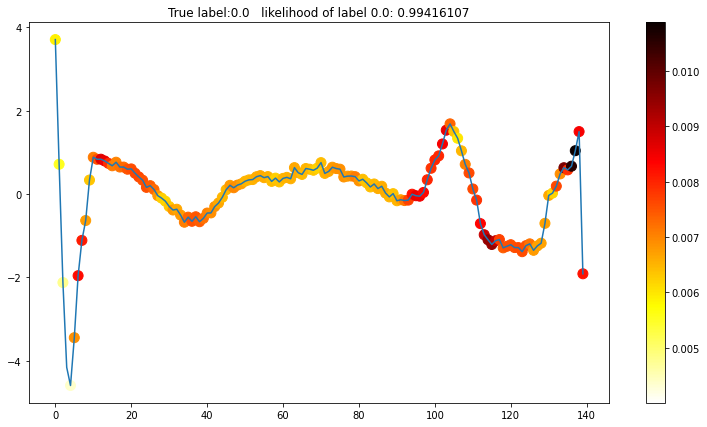

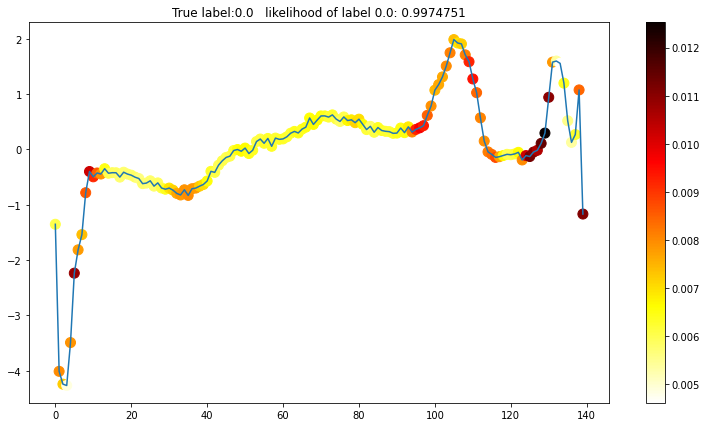

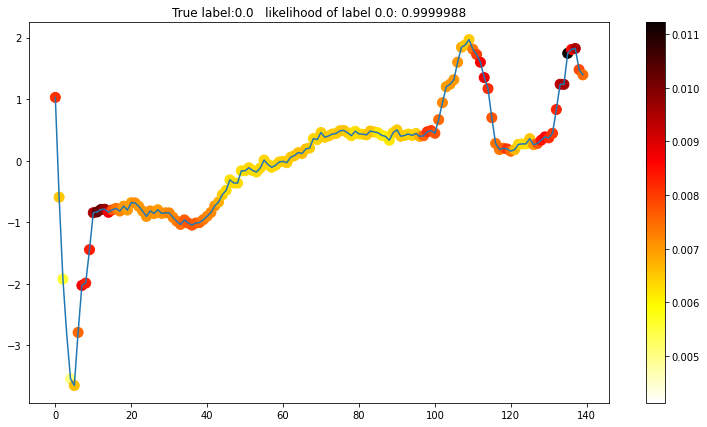

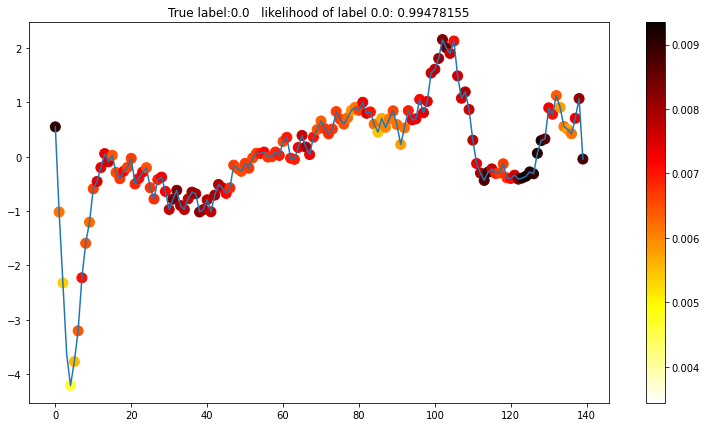

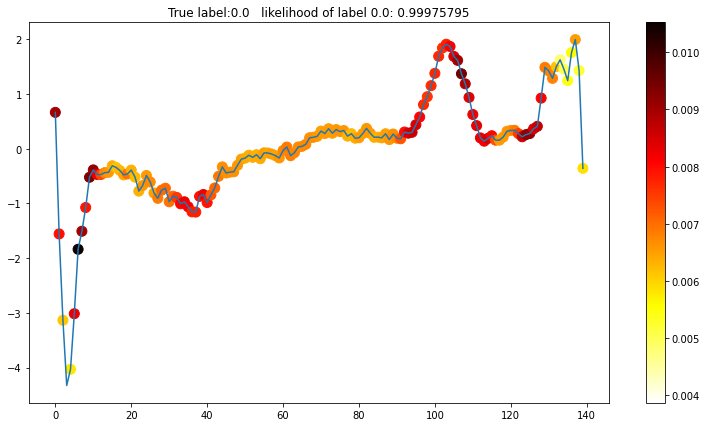

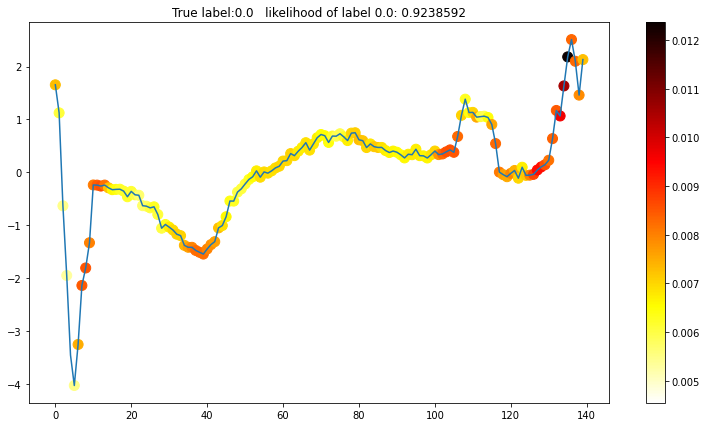

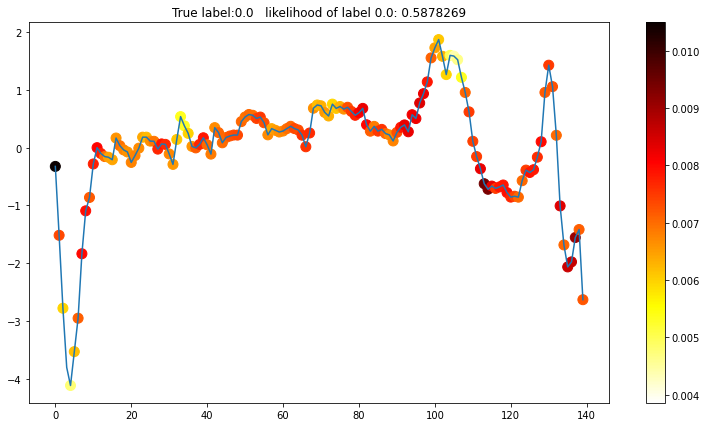

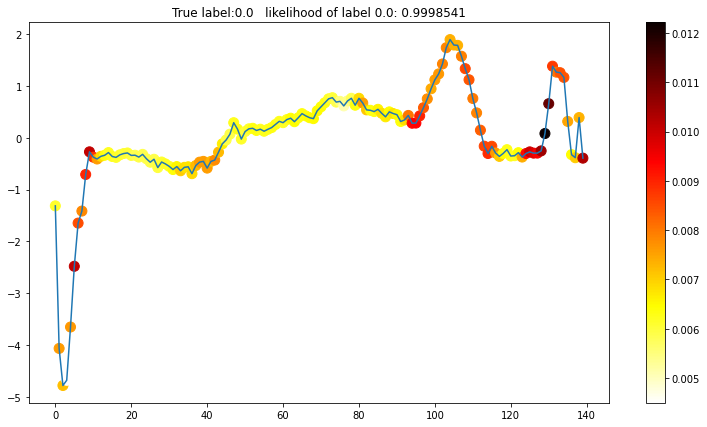

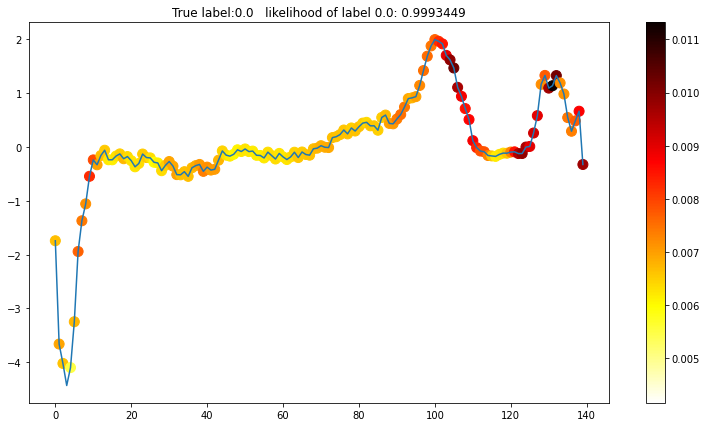

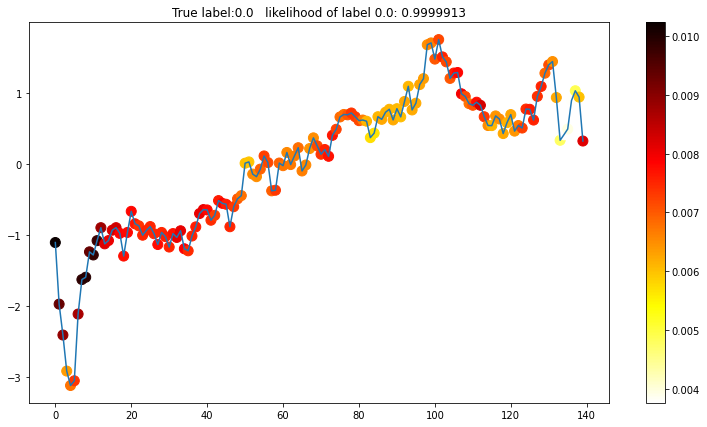

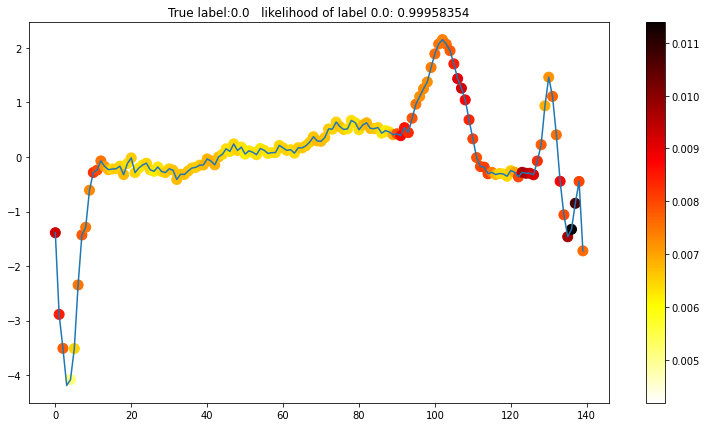

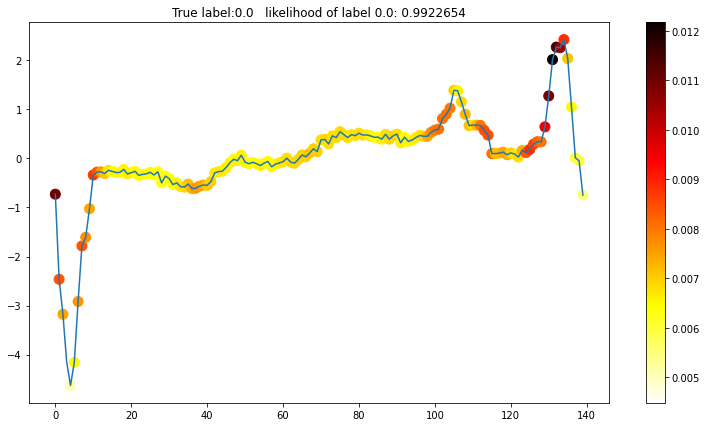

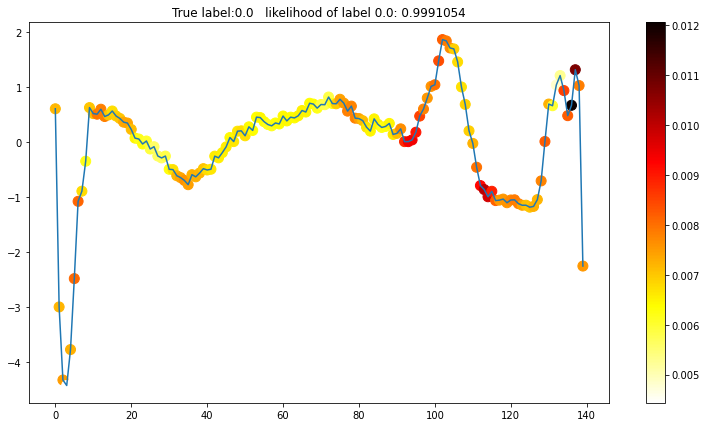

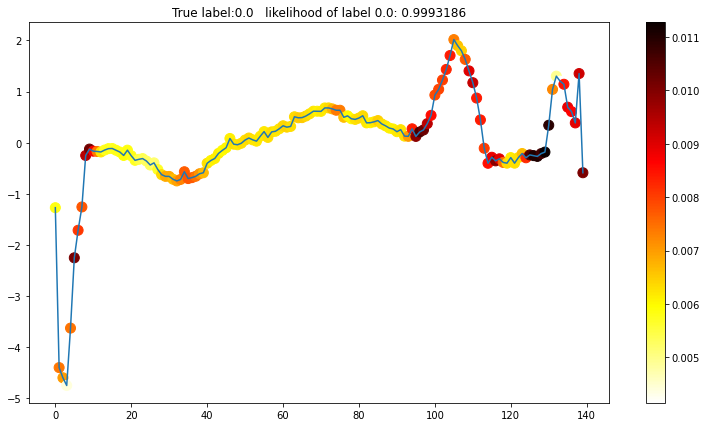

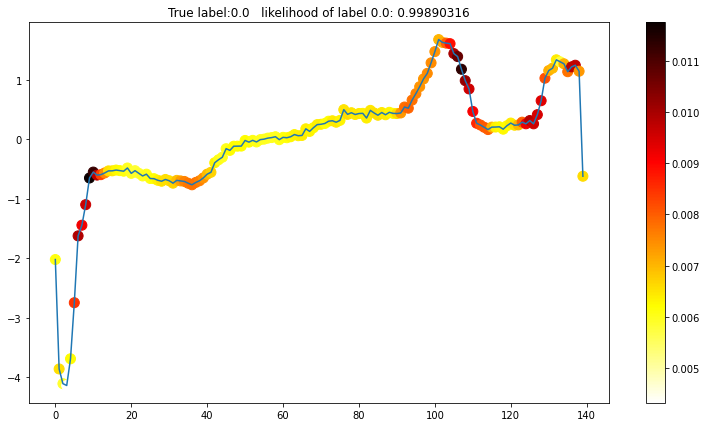

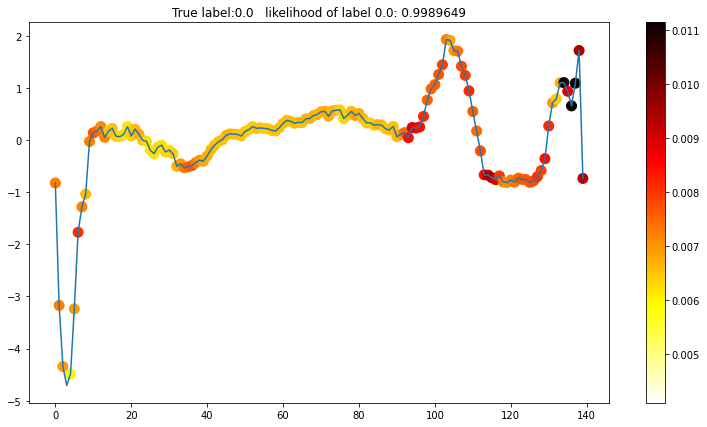

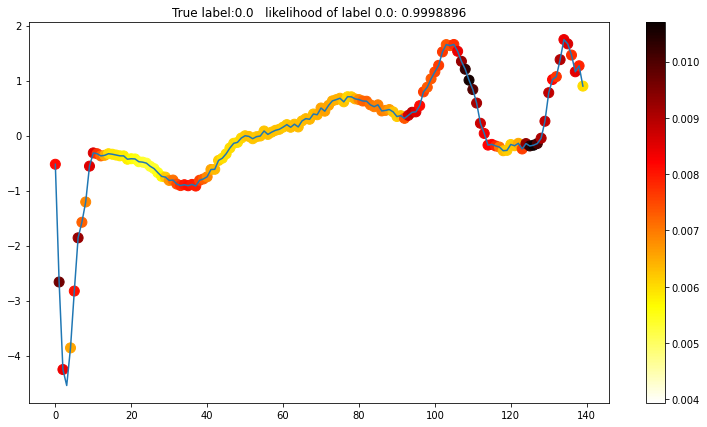

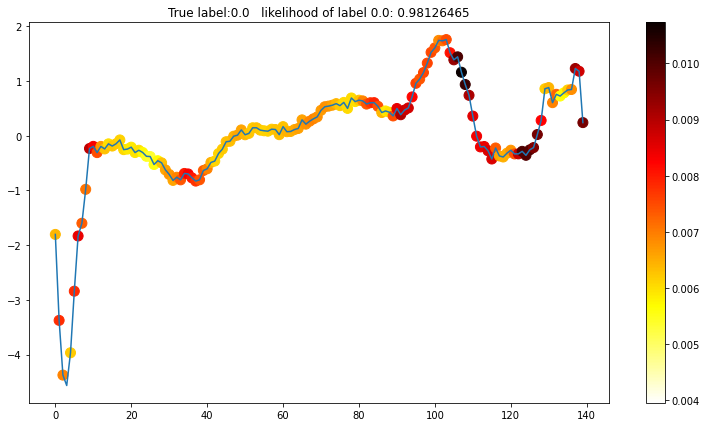

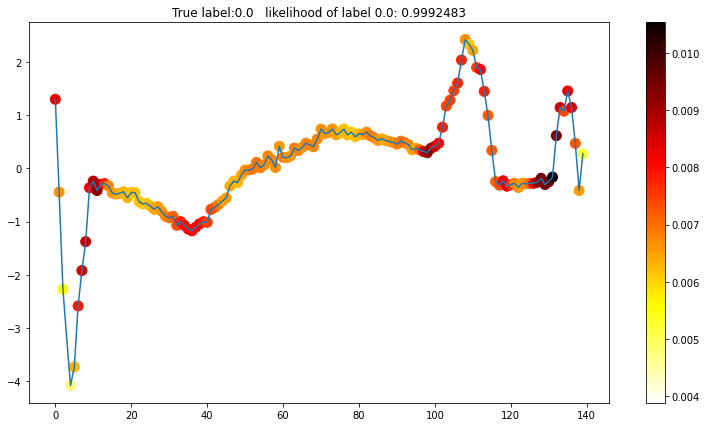

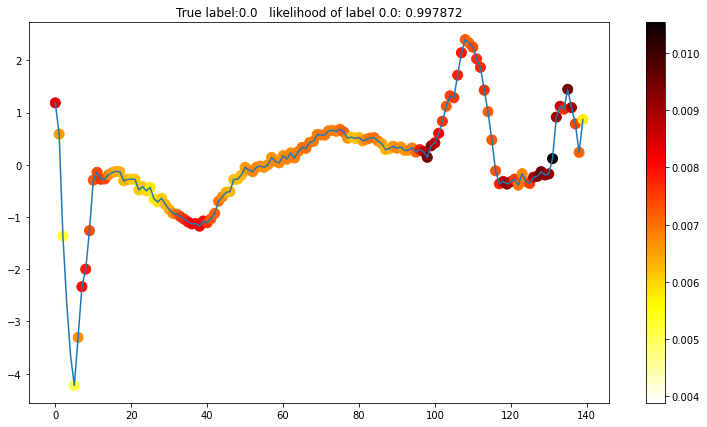

In [21]:
import matplotlib.pyplot as plt
#from matplotlib.backends.backend_pdf import PdfPages
#plt.rcParams.update({'figure.max_open_warning': 0})

get_last_conv = keras.backend.function([model.layers[0].input, keras.backend.learning_phase()], [model.layers[-3].output])
last_conv = get_last_conv([x_test[:100], 1])[0]

get_softmax = keras.backend.function([model.layers[0].input, keras.backend.learning_phase()], [model.layers[-1].output])
softmax = get_softmax(([x_test[:100], 1]))[0]
softmax_weight = model.get_weights()[-2]
CAM = np.dot(last_conv, softmax_weight)


#pp = PdfPages('CAM.pdf')
for k in range(20):
    CAM = (CAM - CAM.min(axis=1, keepdims=True)) / (CAM.max(axis=1, keepdims=True) - CAM.min(axis=1, keepdims=True))
    c = np.exp(CAM) / np.sum(np.exp(CAM), axis=1, keepdims=True)
    plt.figure(figsize=(13, 7));
    plt.plot(x_test[k].squeeze());
    plt.scatter(np.arange(len(x_test[k])), x_test[k].squeeze(), cmap='hot_r', c=c[k, :, :, int(y_test[k])].squeeze(), s=100);
    plt.title(
        'True label:' + str(y_test[k]) + '   likelihood of label ' + str(y_test[k]) + ': ' + str(softmax[k][int(y_test[k])]))
    plt.colorbar();
    plt.show()
    #plt.close('all')
    #pp.savefig()

In [0]:
def viz_cam(root_dir):
    import tensorflow.keras as keras
    import sklearn
    classifier = 'resnet'
    archive_name = 'UCRArchive_2018'
    dataset_name = 'GunPoint'

    if dataset_name == 'Gun_Point':
        save_name = 'GunPoint'
    else:
        save_name = dataset_name
    max_length = 2000
    datasets_dict = read_dataset(root_dir, archive_name, dataset_name)

    x_train = datasets_dict[dataset_name][0]
    y_train = datasets_dict[dataset_name][1]
    y_test = datasets_dict[dataset_name][3]

    # transform to binary labels
    enc = sklearn.preprocessing.OneHotEncoder()
    enc.fit(np.concatenate((y_train, y_test), axis=0).reshape(-1, 1))
    y_train_binary = enc.transform(y_train.reshape(-1, 1)).toarray()

    x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)

    model = keras.models.load_model(
        root_dir + 'results/' + classifier + '/' + archive_name + '/' + dataset_name + '/best_model.hdf5')

    # filters
    w_k_c = model.layers[-1].get_weights()[0]  # weights for each filter k for each class c

    # the same input
    new_input_layer = model.inputs
    # output is both the original as well as the before last layer
    new_output_layer = [model.layers[-3].output, model.layers[-1].output]

    new_feed_forward = keras.backend.function(new_input_layer, new_output_layer)

    classes = np.unique(y_train)
    
    for c in classes:
        plt.figure()
        count = 0
        c_x_train = x_train[np.where(y_train == c)]
        for ts in c_x_train:
            ts = ts.reshape(1, -1, 1)
            [conv_out, predicted] = new_feed_forward([ts])
            pred_label = np.argmax(predicted)
            orig_label = np.argmax(enc.transform([[c]]))
            if pred_label == orig_label:
                cas = np.zeros(dtype=np.float, shape=(conv_out.shape[1]))
                for k, w in enumerate(w_k_c[:, orig_label]):
                    cas += w * conv_out[0, :, k]

                minimum = np.min(cas)

                cas = cas - minimum

                cas = cas / max(cas)
                cas = cas * 100

                x = np.linspace(0, ts.shape[1] - 1, max_length, endpoint=True)
                # linear interpolation to smooth
                f = interp1d(range(ts.shape[1]), ts[0, :, 0])
                y = f(x)
                # if (y < -2.2).any():
                #     continue
                f = interp1d(range(ts.shape[1]), cas)
                cas = f(x).astype(int)
                plt.scatter(x=x, y=y, c=cas, cmap='jet', marker='.', s=2, vmin=0, vmax=100, linewidths=0.0)
                if dataset_name == 'Gun_Point':
                    if c == 1:
                        plt.yticks([-1.0, 0.0, 1.0, 2.0])
                    else:
                        plt.yticks([-2, -1.0, 0.0, 1.0, 2.0])
                count += 1

        cbar = plt.colorbar()
        # cbar.ax.set_yticklabels([100,75,50,25,0])
        plt.savefig(root_dir + '/temp/' + classifier + '-cam-' + save_name + '-class-' + str(int(c)) + '.png',
                    bbox_inches='tight', dpi=1080)